In [1]:
# Check Pytorch installation
import torch, torchvision

# Check MMAction2 installation
import mmaction

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

In [3]:
# Check the directory structure of the tiny data
!tree ../data/

../data/
|-- kinetics_tiny_train_video.txt
|-- kinetics_tiny_val_video.txt
|-- train
|   |-- 27_CSXByd3s.mp4
|   |-- 34XczvTaRiI.mp4
|   |-- A-wiliK50Zw.mp4
|   |-- D32_1gwq35E.mp4
|   |-- D92m0HsHjcQ.mp4
|   |-- DbX8mPslRXg.mp4
|   |-- FMlSTTpN3VY.mp4
|   |-- IyfILH9lBRo.mp4
|   |-- LvcFDgCAXQs.mp4
|   |-- O46YA8tI530.mp4
|   |-- P5M-hAts7MQ.mp4
|   |-- PnOe3GZRVX8.mp4
|   |-- R8HXQkdgKWA.mp4
|   |-- RqnKtCEoEcA.mp4
|   |-- T_TMNGzVrDk.mp4
|   |-- TkkZPZHbAKA.mp4
|   |-- WWP5HZJsg-o.mp4
|   |-- WaS0qwP46Us.mp4
|   |-- Wh_YPQdH1Zg.mp4
|   |-- ZQV4U2KQ370.mp4
|   |-- h10B9SVE-nk.mp4
|   |-- h2YqqUhnR34.mp4
|   |-- iRuyZSKhHRg.mp4
|   |-- kFC3KY2bOP8.mp4
|   |-- oMrZaozOvdQ.mp4
|   |-- oXy-e_P_cAI.mp4
|   |-- phDqGd0NKoo.mp4
|   |-- soEcZZsBmDs.mp4
|   |-- xGY2dP0YUjA.mp4
|   `-- yLC9CtWU5ws.mp4
`-- val
    |-- 0pVGiAU6XEA.mp4
    |-- AQrbRSnRt8M.mp4
    |-- IcLztCtvhb8.mp4
    |-- SU_x2LQqSLs.mp4
    |-- b6Q_b7vgc7Q.mp4
    |-- ddvJ6-faICE.mp4
    |-- ik4BW3-SCts.mp4
    |-- jqRrH30V0k4

In [4]:
# We need to check the annotation format
!cat ../data/kinetics_tiny_train_video.txt

D32_1gwq35E.mp4 0
iRuyZSKhHRg.mp4 1
oXy-e_P_cAI.mp4 0
34XczvTaRiI.mp4 1
h2YqqUhnR34.mp4 0
O46YA8tI530.mp4 0
kFC3KY2bOP8.mp4 1
WWP5HZJsg-o.mp4 1
phDqGd0NKoo.mp4 1
yLC9CtWU5ws.mp4 0
27_CSXByd3s.mp4 1
IyfILH9lBRo.mp4 1
T_TMNGzVrDk.mp4 1
TkkZPZHbAKA.mp4 0
PnOe3GZRVX8.mp4 1
soEcZZsBmDs.mp4 1
FMlSTTpN3VY.mp4 1
WaS0qwP46Us.mp4 0
A-wiliK50Zw.mp4 1
oMrZaozOvdQ.mp4 1
ZQV4U2KQ370.mp4 0
DbX8mPslRXg.mp4 1
h10B9SVE-nk.mp4 1
P5M-hAts7MQ.mp4 0
R8HXQkdgKWA.mp4 0
D92m0HsHjcQ.mp4 0
RqnKtCEoEcA.mp4 0
LvcFDgCAXQs.mp4 0
xGY2dP0YUjA.mp4 0
Wh_YPQdH1Zg.mp4 0


# Train

In [4]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

In [5]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = '../data/train/'
cfg.data_root_val = '../data/val/'
cfg.ann_file_train = '../data/kinetics_tiny_train_video.txt'
cfg.ann_file_val = '../data/kinetics_tiny_val_video.txt'
cfg.ann_file_test = '../data/kinetics_tiny_val_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = '../data/kinetics_tiny_val_video.txt'
cfg.data.test.data_prefix = '../data/val/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = '../data/kinetics_tiny_train_video.txt'
cfg.data.train.data_prefix = '../data/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = '../data/kinetics_tiny_val_video.txt'
cfg.data.val.data_prefix = '../data/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 2
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
cfg.total_epochs = 30

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 10
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=2,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=7.8125e-05, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(policy='step', step=[40, 80])
total_epochs = 30
checkpoint_config = dict(interval=10)
log_config = dict(interval=5, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'VideoDataset'
data_root =

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

Use load_from_torchvision loader


2021-03-18 03:09:12,001 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}
2021-03-18 03:09:15,019 - mmaction - INFO - load checkpoint from ./checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth
2021-03-18 03:09:15,021 - mmaction - INFO - Use load_from_local loader
2021-03-18 03:09:15,549 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([2]).
2021-03-18 03:09:15,551 - mmaction - INFO - Start running, host: root@8ff22ddb9663, work_dir: /mlsteam/lab/tutorial_exps
2021-03-18 03:09:15,555 - mmaction - INFO - workflow: [('train', 1)], max: 30 epochs
/mlsteam/lab/mmaction/core/evaluation/eval_hook

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.3 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:09:45,717 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:09:45,719 - mmaction - INFO - 
top1_acc	0.7000
top5_acc	1.0000
2021-03-18 03:09:45,720 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:09:45,732 - mmaction - INFO - 
mean_acc	0.7000
2021-03-18 03:09:46,081 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-18 03:09:46,082 - mmaction - INFO - Best top1_acc is 0.7000 at 5 epoch.
2021-03-18 03:09:46,083 - mmaction - INFO - Epoch(val) [5][15]	top1_acc: 0.7000, top5_acc: 1.0000, mean_class_accuracy: 0.7000
2021-03-18 03:09:50,577 - mmaction - INFO - Epoch [6][5/15]	lr: 7.813e-05, eta: 0:02:29, time: 0.867, data_time: 0.717, memory: 1654, top1_acc: 0.5000, top5_acc: 1.0000, loss_cls: 0.6696, loss: 0.6696, grad_norm: 11.0204
2021-03-18 03:09:51,242 - mmaction - INFO - Epoch [6][10/15]	lr: 7.813e-05, eta: 0:02:22, time: 0.133, data_time: 0.002, memory: 1654, top1_acc: 0.6000, top5_acc: 1.0000, loss_cl

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.6 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:10:16,070 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:10:16,071 - mmaction - INFO - 
top1_acc	0.9000
top5_acc	1.0000
2021-03-18 03:10:16,073 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:10:16,074 - mmaction - INFO - 
mean_acc	0.9000
2021-03-18 03:10:16,391 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-18 03:10:16,392 - mmaction - INFO - Best top1_acc is 0.9000 at 10 epoch.
2021-03-18 03:10:16,393 - mmaction - INFO - Epoch(val) [10][15]	top1_acc: 0.9000, top5_acc: 1.0000, mean_class_accuracy: 0.9000
2021-03-18 03:10:20,488 - mmaction - INFO - Epoch [11][5/15]	lr: 7.813e-05, eta: 0:01:53, time: 0.784, data_time: 0.633, memory: 1654, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5358, loss: 0.5358, grad_norm: 8.8025
2021-03-18 03:10:21,374 - mmaction - INFO - Epoch [11][10/15]	lr: 7.813e-05, eta: 0:01:49, time: 0.177, data_time: 0.035, memory: 1654, top1_acc: 0.8000, top5_acc: 1.0000, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.4 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:10:46,037 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:10:46,039 - mmaction - INFO - 
top1_acc	0.8000
top5_acc	1.0000
2021-03-18 03:10:46,040 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:10:46,042 - mmaction - INFO - 
mean_acc	0.8000
2021-03-18 03:10:46,043 - mmaction - INFO - Epoch(val) [15][15]	top1_acc: 0.8000, top5_acc: 1.0000, mean_class_accuracy: 0.8000
2021-03-18 03:10:49,954 - mmaction - INFO - Epoch [16][5/15]	lr: 7.813e-05, eta: 0:01:23, time: 0.781, data_time: 0.615, memory: 1654, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5428, loss: 0.5428, grad_norm: 10.0117
2021-03-18 03:10:51,021 - mmaction - INFO - Epoch [16][10/15]	lr: 7.813e-05, eta: 0:01:20, time: 0.214, data_time: 0.069, memory: 1654, top1_acc: 0.7000, top5_acc: 1.0000, loss_cls: 0.6098, loss: 0.6098, grad_norm: 11.1601
2021-03-18 03:10:51,574 - mmaction - INFO - Epoch [16][15/15]	lr: 7.813e-05, eta: 0:01:17, time: 0.111, data_time: 0.001, memory: 1654, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.1 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:11:15,941 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:11:15,943 - mmaction - INFO - 
top1_acc	0.9000
top5_acc	1.0000
2021-03-18 03:11:15,944 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:11:15,946 - mmaction - INFO - 
mean_acc	0.9000
2021-03-18 03:11:15,947 - mmaction - INFO - Epoch(val) [20][15]	top1_acc: 0.9000, top5_acc: 1.0000, mean_class_accuracy: 0.9000
2021-03-18 03:11:19,729 - mmaction - INFO - Epoch [21][5/15]	lr: 7.813e-05, eta: 0:00:54, time: 0.752, data_time: 0.612, memory: 1654, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4515, loss: 0.4515, grad_norm: 8.3868
2021-03-18 03:11:20,684 - mmaction - INFO - Epoch [21][10/15]	lr: 7.813e-05, eta: 0:00:52, time: 0.194, data_time: 0.049, memory: 1654, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4543, loss: 0.4543, grad_norm: 9.0965
2021-03-18 03:11:21,385 - mmaction - INFO - Epoch [21][15/15]	lr: 7.813e-05, eta: 0:00:49, time: 0.140, data_time: 0.028, memory: 1654, to

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.0 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:11:46,991 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:11:46,993 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-03-18 03:11:46,993 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:11:46,996 - mmaction - INFO - 
mean_acc	1.0000
2021-03-18 03:11:47,451 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-03-18 03:11:47,452 - mmaction - INFO - Best top1_acc is 1.0000 at 25 epoch.
2021-03-18 03:11:47,453 - mmaction - INFO - Epoch(val) [25][15]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000
2021-03-18 03:11:51,454 - mmaction - INFO - Epoch [26][5/15]	lr: 7.813e-05, eta: 0:00:26, time: 0.799, data_time: 0.652, memory: 1654, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3759, loss: 0.3759, grad_norm: 7.9680
2021-03-18 03:11:52,470 - mmaction - INFO - Epoch [26][10/15]	lr: 7.813e-05, eta: 0:00:24, time: 0.203, data_time: 0.077, memory: 1654, top1_acc: 0.5000, top5_acc: 1.0000, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 6.2 task/s, elapsed: 2s, ETA:     0s

2021-03-18 03:12:17,458 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-18 03:12:17,460 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-03-18 03:12:17,462 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-18 03:12:17,463 - mmaction - INFO - 
mean_acc	1.0000
2021-03-18 03:12:17,464 - mmaction - INFO - Epoch(val) [30][15]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000


# Test

In [15]:
!python long_video_demo.py configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py  checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth demo/demo.mp4 demo/label_map_k400.txt demo_out.mp4  --input-step 3 --threshold 0.2

Use load_from_local loader
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 280/280, 4.4 task/s, elapsed: 63s, ETA:     0s

# Show the results

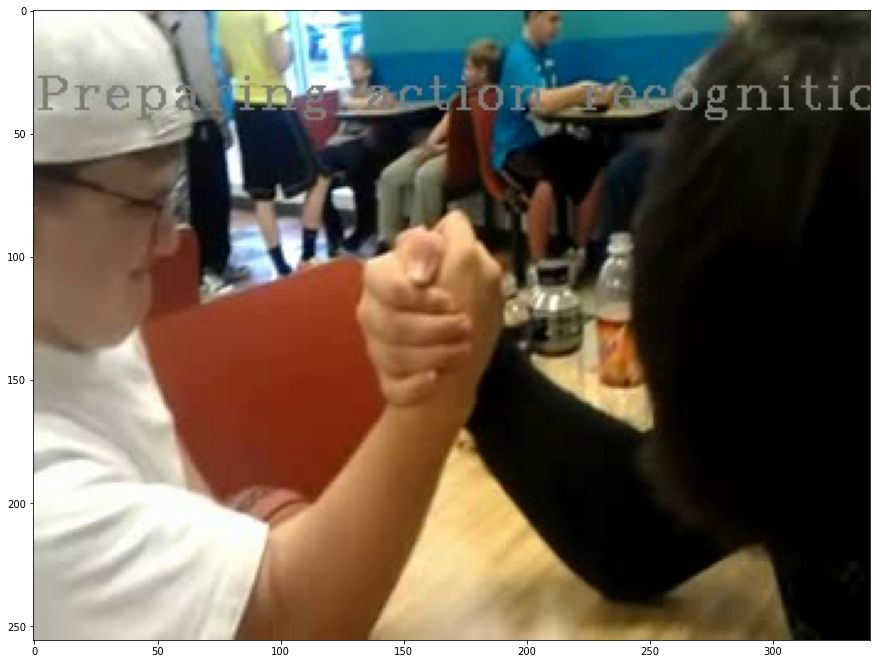

In [17]:
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

cap = cv2.VideoCapture('demo_out.mp4')

plt.rcParams["figure.figsize"] = (15, 15)
while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)

        display.clear_output(wait=True)
        display.display(plt.gcf())

    except KeyboardInterrupt:
        cap.release()